In [0]:
#https://www.tensorflow.org/tutorials/customization/custom_training_walkthrough

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

# TensorFlow and tf.keras
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
from tensorflow import keras
import numpy as np

#Purpose
This guide uses machine learning to categorize Iris flowers by species. It uses TensorFlow to:

    1. Build a model,
    2. Train this model on example data, and
    3. Use the model to make predictions about unknown data.


#TensorFlow programming

This guide uses these high-level TensorFlow concepts:

    1. Use TensorFlow's default eager execution development environment,
    2. Import data with the Datasets API,
    3. Build models and layers with TensorFlow's Keras API.

This tutorial is structured like many TensorFlow programs:

    1. Import and parse the dataset.
    2. Select the type of model.
    3. Train the model.
    4. Evaluate the model's effectiveness.
    5. Use the trained model to make predictions.


#Setup program
Configure imports

Import TensorFlow and the other required Python modules. By default, TensorFlow uses eager execution to evaluate operations immediately, returning concrete values instead of creating a computational graph that is executed later. If you are used to a REPL or the python interactive console, this feels familiar.

In [0]:
import os
import matplotlib.pyplot as plt

#Import and parse the training dataset

Download the dataset file and convert it into a structure that can be used by this Python program.
Download the dataset

Download the training dataset file using the `tf.keras.utils.get_file` function. This returns the file path of the downloaded file:

In [55]:
train_dataset_url = "https://storage.googleapis.com/download.tensorflow.org/data/iris_training.csv"

train_dataset_fp = tf.keras.utils.get_file(fname=os.path.basename(train_dataset_url),
                                           origin=train_dataset_url)

print("Local copy of the dataset file: {}".format(train_dataset_fp))


Local copy of the dataset file: /root/.keras/datasets/iris_training.csv


#Inspect the data

This dataset, iris_training.csv, is a plain text file that stores tabular data formatted as comma-separated values (CSV). Use the head -n5 command to take a peek at the first five entries:

In [56]:
!head -n5 {train_dataset_fp} #show 5 columns of data

120,4,setosa,versicolor,virginica
6.4,2.8,5.6,2.2,2
5.0,2.3,3.3,1.0,1
4.9,2.5,4.5,1.7,2
4.9,3.1,1.5,0.1,0


From this view of the dataset, notice the following:

    1. The first line is a header containing information about the dataset:
        There are 120 total examples. Each example has four features and one of three possible label names.
    2. Subsequent rows are data records, one example per line, where:
        The first four fields are features: these are the characteristics of an example. Here, the fields hold float numbers representing flower measurements.
        The last column is the label: this is the value we want to predict. For this dataset, it's an integer value of 0, 1, or 2 that corresponds to a flower name.


In [57]:
# column order in CSV file
column_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species']

feature_names = column_names[:-1]
label_name = column_names[-1]

print("Features: {}".format(feature_names))
print("Label: {}".format(label_name))


Features: ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
Label: species


In [0]:
#Each label is associated with string name (for example, "setosa"), but machine learning typically relies on numeric values. 
class_names = ['Iris setosa', 'Iris versicolor', 'Iris virginica']


#Create a `tf.data.Dataset`

TensorFlow's Dataset API handles many common cases for loading data into a model. This is a high-level API for reading data and transforming it into a form used for training.

Since the dataset is a CSV-formatted text file, use the `tf.data.experimental.make_csv_dataset` function to parse the data into a suitable format. Since this function generates data for training models, the default behavior is to shuffle the data (shuffle=True, shuffle_buffer_size=10000), and repeat the dataset forever (num_epochs=None). We also set the batch_size parameter:

In [59]:
batch_size = 32

train_dataset = tf.data.experimental.make_csv_dataset(
    train_dataset_fp,
    batch_size,
    column_names=column_names,
    label_name=label_name,
    num_epochs=1)

train_dataset #returns a PrefetchDataset

<PrefetchDataset shapes: (OrderedDict([(sepal_length, (None,)), (sepal_width, (None,)), (petal_length, (None,)), (petal_width, (None,))]), (None,)), types: (OrderedDict([(sepal_length, tf.float32), (sepal_width, tf.float32), (petal_length, tf.float32), (petal_width, tf.float32)]), tf.int32)>

The `make_csv_dataset` function returns a tf.data.Dataset of (features, label) pairs, where features is a dictionary: `{'feature_name': value}`

These Dataset objects are iterable. Let's look at a batch of features:

In [60]:
features, labels = next(iter(train_dataset)) #get a single batch of data.
print(features)


OrderedDict([('sepal_length', <tf.Tensor: shape=(32,), dtype=float32, numpy=
array([6.4, 5.4, 6.3, 6.6, 5.7, 4.9, 5.5, 6.8, 5.9, 5.7, 6.7, 6.2, 6.8,
       5.4, 6. , 5. , 5.1, 5.4, 4.4, 6.1, 5.5, 4.9, 4.8, 6.9, 7.7, 7.2,
       4.4, 7. , 6.5, 6.1, 6.4, 4.7], dtype=float32)>), ('sepal_width', <tf.Tensor: shape=(32,), dtype=float32, numpy=
array([2.8, 3.9, 2.7, 3. , 3.8, 3.1, 2.4, 3. , 3.2, 3. , 3.1, 3.4, 3.2,
       3.9, 2.7, 3.5, 3.8, 3. , 3. , 2.8, 2.4, 3. , 3.1, 3.1, 2.8, 3.2,
       2.9, 3.2, 3. , 3. , 3.2, 3.2], dtype=float32)>), ('petal_length', <tf.Tensor: shape=(32,), dtype=float32, numpy=
array([5.6, 1.3, 4.9, 4.4, 1.7, 1.5, 3.7, 5.5, 4.8, 4.2, 4.4, 5.4, 5.9,
       1.7, 5.1, 1.3, 1.5, 4.5, 1.3, 4. , 3.8, 1.4, 1.6, 5.1, 6.7, 6. ,
       1.4, 4.7, 5.8, 4.9, 5.3, 1.6], dtype=float32)>), ('petal_width', <tf.Tensor: shape=(32,), dtype=float32, numpy=
array([2.2, 0.4, 1.8, 1.4, 0.3, 0.1, 1. , 2.1, 1.8, 1.2, 1.4, 2.3, 2.3,
       0.4, 1.6, 0.3, 0.3, 1.5, 0.2, 1.3, 1.1, 0.2, 0.2, 2.3,

Notice that like-features are grouped together, or batched. Each example row's fields are appended to the corresponding feature array. Change the batch_size to set the number of examples stored in these feature arrays.

You can start to see some clusters by plotting a few features from the batch:

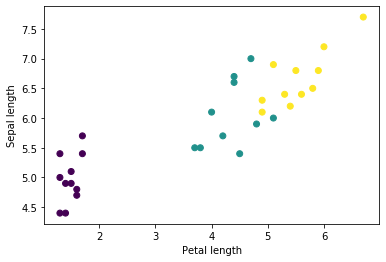

In [61]:
plt.scatter(features['petal_length'],
            features['sepal_length'],
            c=labels,
            cmap='viridis')

plt.xlabel("Petal length")
plt.ylabel("Sepal length")
plt.show()


To simplify the model building step, create a function to repackage the features dictionary into a single array with shape: (batch_size, num_features).

This function uses the `tf.stack` method which takes values from a list of tensors and creates a combined tensor at the specified dimension:

In [0]:
#basically a function to stack features, the labels are returned the same
def pack_features_vector(features, labels):
  """Pack the features into a single array."""
  features = tf.stack(list(features.values()), axis=1)
  return features, labels

Then use the `tf.data.Dataset`#map method to pack the features of each (features,label) pair into the training dataset:

In [0]:
train_dataset = train_dataset.map(pack_features_vector) #apply the function to all data(batch?) in the dataset
#Transforms it into MapDataset.

In [64]:
train_dataset

<MapDataset shapes: ((None, 4), (None,)), types: (tf.float32, tf.int32)>

The features element of the Dataset are now arrays with shape (batch_size, num_features). Let's look at the first few examples:

In [65]:
features, labels = next(iter(train_dataset))
print(features[:5])
print(labels[:5])


tf.Tensor(
[[5.8 4.  1.2 0.2]
 [6.7 3.3 5.7 2.1]
 [6.9 3.1 4.9 1.5]
 [6.  2.7 5.1 1.6]
 [5.7 2.8 4.5 1.3]], shape=(5, 4), dtype=float32)
tf.Tensor([0 2 1 1 1], shape=(5,), dtype=int32)


#Select the type of model
(This text is real long, just check the documentation)
Basically it says that a model is just something that tries to approximate a function. And we use a fully-connected-neural-network here to try and define that function

#Create a model using Keras

The TensorFlow `tf.keras` API is the preferred way to create models and layers. This makes it easy to build models and experiment while Keras handles the complexity of connecting everything together.

The `tf.keras.Sequential` model is a linear stack of layers. Its constructor takes a list of layer instances, in this case, two `tf.keras.layers.Dense` layers with 10 nodes each, and an output layer with 3 nodes representing our label predictions. The first layer's `input_shape` parameter corresponds to the number of features from the dataset, and is required:

In [0]:
model = tf.keras.Sequential([
  tf.keras.layers.Dense(10, activation=tf.nn.relu, input_shape=(4,)),  # input shape required
  tf.keras.layers.Dense(10, activation=tf.nn.relu),
  tf.keras.layers.Dense(3)
])


The activation function determines the output shape of each node in the layer. These non-linearities are important—without them the model would be equivalent to a single layer. There are many tf.keras.activations, but ReLU is common for hidden layers.

The ideal number of hidden layers and neurons depends on the problem and the dataset. Like many aspects of machine learning, picking the best shape of the neural network requires a mixture of knowledge and experimentation. As a rule of thumb, increasing the number of hidden layers and neurons typically creates a more powerful model, which requires more data to train effectively.

#Using the model

Let's have a quick look at what this model does to a batch of features:

In [67]:
predictions = model(features)
predictions[:5] #five logi
#Here, each example returns a logit for each class.
#To convert these logits to a probability for each class, use the softmax function:

<tf.Tensor: shape=(5, 3), dtype=float32, numpy=
array([[-0.9971866 , -0.7804966 ,  1.194075  ],
       [-1.3565173 , -1.0480316 ,  0.29397655],
       [-1.2815508 , -0.92553437,  0.5154767 ],
       [-1.1733143 , -0.8499735 ,  0.28559637],
       [-1.1069468 , -0.7979062 ,  0.36060005]], dtype=float32)>

In [68]:
#the softmax function
tf.nn.softmax(predictions[:5])
#if you add them you get 1

<tf.Tensor: shape=(5, 3), dtype=float32, numpy=
array([[0.08937788, 0.11100365, 0.7996185 ],
       [0.13208444, 0.17981477, 0.6881008 ],
       [0.11821278, 0.16876422, 0.713023  ],
       [0.14963323, 0.20675366, 0.64361316],
       [0.14923818, 0.20328   , 0.64748174]], dtype=float32)>

In [69]:
#Taking the tf.argmax across classes gives us the predicted class index. 
#But, the model hasn't been trained yet, so these aren't good predictions:
print("Prediction: {}".format(tf.argmax(predictions, axis=1)))
print("    Labels: {}".format(labels))
#Predictions for the batch

Prediction: [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
    Labels: [0 2 1 1 1 0 2 0 1 2 2 0 2 2 2 2 1 0 0 1 0 2 2 0 0 2 2 1 2 1 1 2]


#Train the model

#Define the loss and gradient function
Both training and evaluation stages need to calculate the model's loss. This measures how off a model's predictions are from the desired label, in other words, how bad the model is performing. We want to minimize, or optimize, this value.

Our model will calculate its loss using the `tf.keras.losses.SparseCategoricalCrossentropy` function which takes the model's class probability predictions and the desired label, and returns the average loss across the examples.

In [70]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
loss_object #It gives a object of SparseCategoricalCrossentropy

In [71]:
#Basically a function telling it to return the loss from the predictions vs real data
def loss(model, x, y, training):
  # training=training is needed only if there are layers with different
  # behavior during training versus inference (e.g. Dropout).
  y_ = model(x, training=training)

  return loss_object(y_true=y, y_pred=y_)


l = loss(model, features, labels, training=False)
print("Loss test: {}".format(l))


Loss test: 1.2401671409606934


In [0]:
#Use the tf.GradientTape context to calculate the gradients used to optimize your model:
def grad(model, inputs, targets):
  with tf.GradientTape() as tape:
    loss_value = loss(model, inputs, targets, training=True) #return the loss of the model
  return loss_value, tape.gradient(loss_value, model.trainable_variables) #return the gradient of the loss vs the trainable_variables 
  #This is to change the variables with the value of the gradients.


#Create an optimizer

An optimizer applies the computed gradients to the model's variables to minimize the loss function. You can think of the loss function as a curved surface and we want to find its lowest point by walking around. The gradients point in the direction of steepest ascent—so we'll travel the opposite way and move down the hill. By iteratively calculating the loss and gradient for each batch, we'll adjust the model during training. Gradually, the model will find the best combination of weights and bias to minimize loss. And the lower the loss, the better the model's predictions.

In [0]:
#Here we use the SGD optimizer, there are plenty to choose from.
#The learning rate is the step size to take for each iteration 'down the hill'
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)

In [74]:
#To calculate a single optimization step we do the following:
loss_value, grads = grad(model, features, labels)
print("Step: {}, Initial Loss: {}".format(optimizer.iterations.numpy(), #Optimizer.iterations returns how many iterations this optimizer has done
                                          loss_value.numpy())) #its like an object

optimizer.apply_gradients(zip(grads, model.trainable_variables)) #the zip seems to be a format necessity
#We basically just apply this gradients to the model based on the optimizer.

print("Step: {},         Loss: {}".format(optimizer.iterations.numpy(),
                                          loss(model, features, labels, training=True).numpy()))


Step: 0, Initial Loss: 1.2401671409606934
Step: 1,         Loss: 1.204746127128601


#Training loop

With all the pieces in place, the model is ready for training! A training loop feeds the dataset examples into the model to help it make better predictions. The following code block sets up these training steps:

    1. Iterate each epoch. An epoch is one pass through the dataset.
    2. Within an epoch, iterate over each example in the training Dataset grabbing its features (x) and label (y).
    3. Using the example's features, make a prediction and compare it with the label. Measure the inaccuracy of the prediction and use that to calculate the model's loss and gradients.
    4. Use an optimizer to update the model's variables.
    5. Keep track of some stats for visualization.
    6. Repeat for each epoch.

The num_epochs variable is the number of times to loop over the dataset collection. Counter-intuitively, training a model longer does not guarantee a better model. num_epochs is a hyperparameter that you can tune. Choosing the right number usually requires both experience and experimentation:

In [75]:
#Basically insted of the model.train() we do it manually
## Note: Rerunning this cell uses the same model variables

# Keep results for plotting
train_loss_results = []
train_accuracy_results = []

num_epochs = 201

for epoch in range(num_epochs):
  epoch_loss_avg = tf.keras.metrics.Mean()
  epoch_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()

  # Training loop - using batches of 32
  for x, y in train_dataset:
    # Optimize the model
    loss_value, grads = grad(model, x, y) #get the single loss value and the gradients of each variable
    optimizer.apply_gradients(zip(grads, model.trainable_variables)) #apply the gradients to each variable

    # Track progress
    epoch_loss_avg(loss_value)  # Add current batch loss #you do some function (average) to the loss, it keeps memory of previous values 
    # Compare predicted label to actual label
    # training=True is needed only if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    epoch_accuracy(y, model(x, training=True)) #This also keeps memory of previous values. 

  # End epoch
  train_loss_results.append(epoch_loss_avg.result())
  train_accuracy_results.append(epoch_accuracy.result())

  if epoch % 50 == 0:
    print("Epoch {:03d}: Loss: {:.3f}, Accuracy: {:.3%}".format(epoch,
                                                                epoch_loss_avg.result(),
                                                                epoch_accuracy.result()))


Epoch 000: Loss: 1.265, Accuracy: 35.000%
Epoch 050: Loss: 0.888, Accuracy: 70.000%
Epoch 100: Loss: 0.454, Accuracy: 76.667%
Epoch 150: Loss: 0.311, Accuracy: 92.500%
Epoch 200: Loss: 0.230, Accuracy: 98.333%


Visualize the loss function over time

While it's helpful to print out the model's training progress, it's often more helpful to see this progress. TensorBoard is a nice visualization tool that is packaged with TensorFlow, but we can create basic charts using the matplotlib module.

Interpreting these charts takes some experience, but you really want to see the loss go down and the accuracy go up:

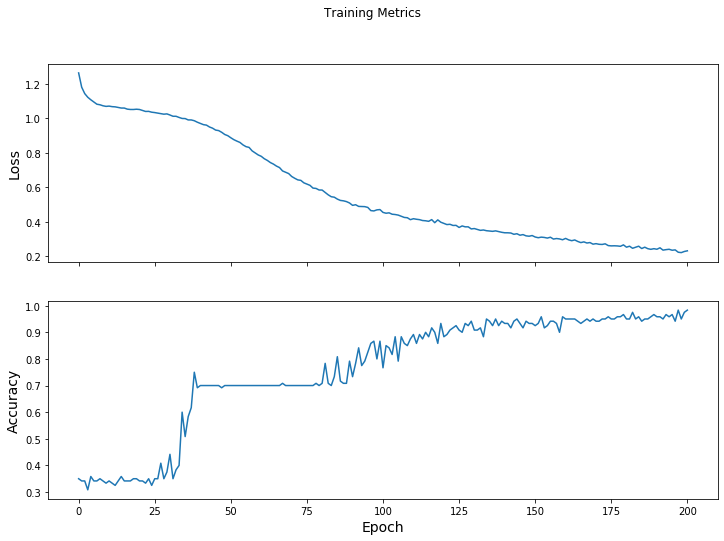

In [76]:
fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
fig.suptitle('Training Metrics')

axes[0].set_ylabel("Loss", fontsize=14)
axes[0].plot(train_loss_results)

axes[1].set_ylabel("Accuracy", fontsize=14)
axes[1].set_xlabel("Epoch", fontsize=14)
axes[1].plot(train_accuracy_results)
plt.show()

#I think the loss value indicates in what magnitude the model is changing,
#When there are little changes in loss there are little changes in accuracy.

#Evaluate the model's effectiveness

Now that the model is trained, we can get some statistics on its performance.

Evaluating means determining how effectively the model makes predictions. To determine the model's effectiveness at Iris classification, pass some sepal and petal measurements to the model and ask the model to predict what Iris species they represent. Then compare the model's predictions against the actual label. For example, a model that picked the correct species on half the input examples has an accuracy of 0.5.

#Setup the test dataset

Evaluating the model is similar to training the model. The biggest difference is the examples come from a separate test set rather than the training set. To fairly assess a model's effectiveness, the examples used to evaluate a model must be different from the examples used to train the model.

The setup for the test Dataset is similar to the setup for training Dataset. Download the CSV text file and parse that values, then give it a little shuffle:

In [77]:
test_url = "https://storage.googleapis.com/download.tensorflow.org/data/iris_test.csv"

test_fp = tf.keras.utils.get_file(fname=os.path.basename(test_url),
                                  origin=test_url)


8192/573 [============================================================================================================================================================================================================================================================================================================================================================================================================================================] - 0s 0us/step


In [0]:
test_dataset = tf.data.experimental.make_csv_dataset(
    test_fp,
    batch_size,
    column_names=column_names,
    label_name='species',
    num_epochs=1,
    shuffle=False)

test_dataset = test_dataset.map(pack_features_vector)


#Evaluate the model on the test dataset

Unlike the training stage, the model only evaluates a single epoch of the test data. In the following code cell, we iterate over each example in the test set and compare the model's prediction against the actual label. This is used to measure the model's accuracy across the entire test set:

In [79]:
test_accuracy = tf.keras.metrics.Accuracy()

for (x, y) in test_dataset:
  # training=False is needed only if there are layers with different
  # behavior during training versus inference (e.g. Dropout).
  logits = model(x, training=False)
  prediction = tf.argmax(logits, axis=1, output_type=tf.int32)
  test_accuracy(prediction, y)

print("Test set accuracy: {:.3%}".format(test_accuracy.result()))


Test set accuracy: 96.667%


In [85]:
#We can see on the last batch, for example, the model is usually correct:
print(tf.stack([y,prediction],axis=1)) #what this does is that it places the real and the prediction next to each other
#if we do it like this:
[y,prediction] #it just gives the two arrays.


tf.Tensor(
[[1 1]
 [2 2]
 [0 0]
 [1 1]
 [1 1]
 [1 1]
 [0 0]
 [2 2]
 [1 1]
 [2 2]
 [2 2]
 [0 0]
 [2 2]
 [1 1]
 [1 1]
 [0 0]
 [1 1]
 [0 0]
 [0 0]
 [2 2]
 [0 0]
 [1 1]
 [2 2]
 [1 2]
 [1 1]
 [1 1]
 [0 0]
 [1 1]
 [2 2]
 [1 1]], shape=(30, 2), dtype=int32)


[<tf.Tensor: shape=(30,), dtype=int32, numpy=
 array([1, 2, 0, 1, 1, 1, 0, 2, 1, 2, 2, 0, 2, 1, 1, 0, 1, 0, 0, 2, 0, 1,
        2, 1, 1, 1, 0, 1, 2, 1], dtype=int32)>,
 <tf.Tensor: shape=(30,), dtype=int32, numpy=
 array([1, 2, 0, 1, 1, 1, 0, 2, 1, 2, 2, 0, 2, 1, 1, 0, 1, 0, 0, 2, 0, 1,
        2, 2, 1, 1, 0, 1, 2, 1], dtype=int32)>]

#Use the trained model to make predictions

We've trained a model and "proven" that it's good—but not perfect—at classifying Iris species. Now let's use the trained model to make some predictions on unlabeled examples; that is, on examples that contain features but not a label.

In real-life, the unlabeled examples could come from lots of different sources including apps, CSV files, and data feeds. For now, we're going to manually provide three unlabeled examples to predict their labels. Recall, the label numbers are mapped to a named representation as:

    0: Iris setosa
    1: Iris versicolor
    2: Iris virginica


In [86]:
predict_dataset = tf.convert_to_tensor([
    [5.1, 3.3, 1.7, 0.5,],
    [5.9, 3.0, 4.2, 1.5,],
    [6.9, 3.1, 5.4, 2.1]
])

# training=False is needed only if there are layers with different
# behavior during training versus inference (e.g. Dropout).
predictions = model(predict_dataset, training=False)

for i, logits in enumerate(predictions):
  class_idx = tf.argmax(logits).numpy()
  p = tf.nn.softmax(logits)[class_idx]
  name = class_names[class_idx]
  print("Example {} prediction: {} ({:4.1f}%)".format(i, name, 100*p))


Example 0 prediction: Iris setosa (97.3%)
Example 1 prediction: Iris versicolor (77.2%)
Example 2 prediction: Iris virginica (67.9%)


In [87]:
predict_dataset

<tf.Tensor: shape=(3, 4), dtype=float32, numpy=
array([[5.1, 3.3, 1.7, 0.5],
       [5.9, 3. , 4.2, 1.5],
       [6.9, 3.1, 5.4, 2.1]], dtype=float32)>